In [ ]:
cd /content/drive/MyDrive/CVL

/content/drive/MyDrive/CVL


In [ ]:
!ls

Authors				   __pycache__
AuthorsDatasetFromDictionary.py    test_1000_03052021.txt
ContrastiveLoss.py		   train_10000_03052021.txt
contrastiveSiameseNetwork.py	   valid_1000_03052021.txt
model_cvl_EuclideanContrastive.pt


In [ ]:
from time import sleep
from threading import Thread
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from contrastiveSiameseNetwork import *
from ContrastiveLoss import *
from torchsummary import summary
from matplotlib import pyplot as plt
from AuthorsDatasetFromDictionary import *
!pip install hdf5storage
import hdf5storage
from skimage import io, transform, color,img_as_ubyte

     |████████████████████████████████| 61kB 5.5MB/s 


In [ ]:
torch.cuda.is_available()

True

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 13:27:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
ImageDictionary = {}

folders = os.listdir(os.path.join('','Authors'))
shuffleArray = folders
random.shuffle(shuffleArray) #inplace shuffling.

pt1ranges = (0,25)
pt2ranges = (25,50)
pt3ranges = (50,75)
pt4ranges = (75,100)
def readTo(shufflearray ,ranges,readinto):
    for folderId in range(ranges[0],ranges[1]):
        files = os.listdir(os.path.join('','Authors',shufflearray[folderId])) 
        for file in files :
          img = io.imread(os.path.join('','Authors',shufflearray[folderId],file))
          img = color.rgb2gray(img)
          img = img_as_ubyte(img)
          readinto[os.path.join('','Authors',shufflearray[folderId],file)] = img
        print(str(folderId) , "is done...")

pt1 = Thread(target = readTo, args = (shuffleArray,pt1ranges,ImageDictionary))
pt2 = Thread(target = readTo, args = (shuffleArray,pt2ranges,ImageDictionary))
pt3 = Thread(target = readTo, args = (shuffleArray,pt3ranges,ImageDictionary))
pt4 = Thread(target = readTo, args = (shuffleArray,pt4ranges,ImageDictionary))

pt1.start()
pt2.start()
pt3.start()
pt4.start()

pt1.join()
pt2.join()
pt3.join()
pt4.join()

0 is done...
75 is done...
50 is done...
25 is done...
76 is done...
51 is done...
1 is done...
26 is done...
77 is done...
52 is done...
27 is done...
2 is done...
53 is done...
78 is done...
28 is done...
3 is done...
54 is done...
79 is done...
4 is done...
29 is done...
55 is done...
80 is done...
5 is done...
30 is done...
81 is done...
56 is done...
6 is done...
31 is done...
82 is done...
7 is done...
57 is done...
32 is done...
83 is done...
8 is done...
58 is done...
84 is done...
33 is done...
9 is done...
59 is done...
85 is done...
34 is done...
10 is done...
86 is done...
60 is done...
35 is done...
11 is done...
61 is done...
87 is done...
36 is done...
12 is done...
62 is done...
88 is done...
37 is done...
63 is done...
13 is done...
89 is done...
38 is done...
14 is done...
64 is done...
39 is done...
90 is done...
65 is done...
40 is done...
91 is done...
15 is done...
66 is done...
92 is done...
16 is done...
41 is done...
67 is done...
17 is done...
42 is done...
93

In [ ]:
root_dir='./'
pathTrain ='/content/drive/MyDrive/CVL/train_10000_03052021.txt'
pathValid ='/content/drive/MyDrive/CVL/valid_1000_03052021.txt'

# Constants from Authors100 dataset
MAXWIDTH = 2387
MAXHEIGHT = 200

train_ds = AuthorsDataset(
    root_dir=root_dir,
    path=pathTrain,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=True),
        Downsample(0.75),
    ]))
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path=pathValid,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

In [ ]:
## Initialize parameters
bs = 128
lr = 0.00006
threshold = 0.05
margin = 0.15
epochs = 100

In [ ]:
## Initialize network
model = ContrastiveSiamese()
model = model.cuda()

In [ ]:
## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize loss
criterion = ContrastiveLoss(margin)

In [ ]:
train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)

In [ ]:
images1, images2, labels = next(iter(train_dl))
images1.shape

torch.Size([128, 1, 150, 150])

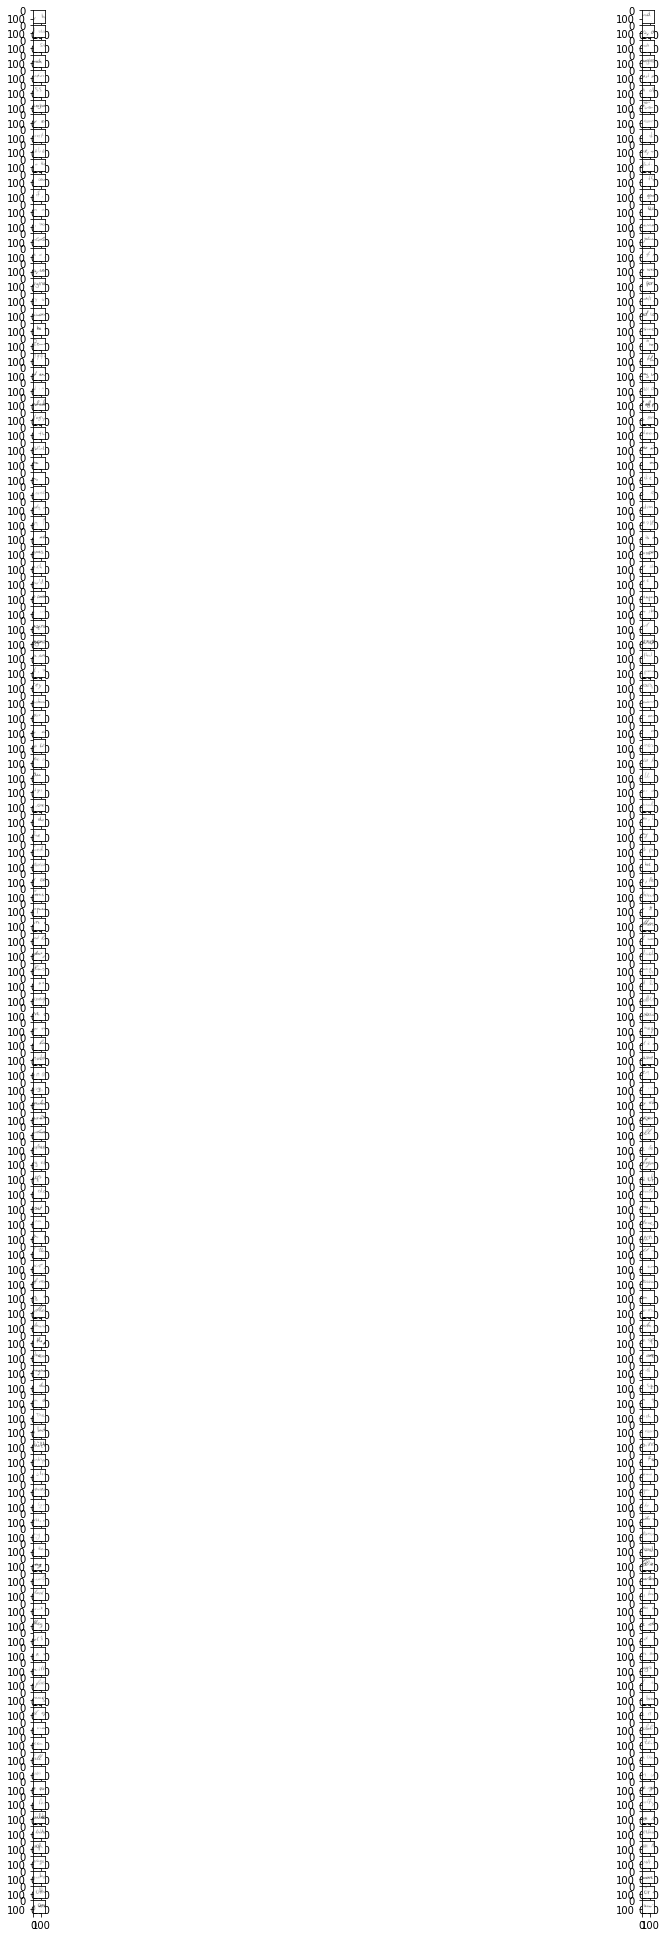

In [ ]:
images1, images2, labels = next(iter(train_dl))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,35)

fig, axs = plt.subplots(bs, 2)
for ii in range(bs):
    axs[ii, 0].imshow(torch.squeeze(images1[ii]), cmap ='gray')
    axs[ii, 1].imshow(torch.squeeze(images2[ii]), cmap ='gray')

In [ ]:
def evaluate_pair(output1,output2,target,threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    cond = euclidean_distance<threshold

    TruePositive = 0
    FalsePositive = 0
    TrueNegative = 0
    FalseNegative = 0



    for i in range(len(cond)):
        if target[i] == True and cond[i] == True:
            TruePositive += 1
        elif target[i] == True and cond[i] == False:
            FalseNegative +=1
        elif target[i] == False and cond[i] == True:
            FalsePositive +=1
        else:
            TrueNegative +=1
    return TruePositive,FalsePositive,TrueNegative,FalseNegative

In [ ]:
train_loss = []
valid_loss = []
valid_acc = []
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.cuda(),input2.cuda())
        
        loss = criterion(output1,output2,target.cuda())
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),threshold)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)
    

    valid_loss.append(valid_epoch_loss)
    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)
    valid_acc.append(valid_acc_value)


    print("Validation loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n Validation Datasize: {}\n".format(valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value,len(valid_ds)))
    # save model if Training loss has decreased
    if valid_epoch_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_epoch_loss))
        torch.save(model.state_dict(), 'model_cvl_EuclideanContrastive.pt')
        valid_loss_min = valid_epoch_loss

Epoch [1/100] ----> Training loss :3.133400769438594e-05 

Validation loss :2.7844141935929657e-05 			  TP: 261, TN: 456, FP: 44, FN: 239, Accuracy = 0.717
 Validation Datasize: 1000

Validation loss decreased (inf --> 0.000028).  Saving model ...
Epoch [2/100] ----> Training loss :2.882608682848513e-05 

Validation loss :2.759149414487183e-05 			  TP: 249, TN: 468, FP: 32, FN: 251, Accuracy = 0.717
 Validation Datasize: 1000

Validation loss decreased (0.000028 --> 0.000028).  Saving model ...
Epoch [3/100] ----> Training loss :2.7715058904141186e-05 

Validation loss :2.6722199749201537e-05 			  TP: 283, TN: 446, FP: 54, FN: 217, Accuracy = 0.729
 Validation Datasize: 1000

Validation loss decreased (0.000028 --> 0.000027).  Saving model ...
Epoch [4/100] ----> Training loss :2.734510765876621e-05 

Validation loss :2.70037273876369e-05 			  TP: 269, TN: 447, FP: 53, FN: 231, Accuracy = 0.716
 Validation Datasize: 1000

Epoch [5/100] ----> Training loss :2.6856965152546763e-05 

Vali

In [ ]:
model = ContrastiveSiamese()
model.load_state_dict(torch.load('/content/drive/MyDrive/CVL/model_cvl_EuclideanContrastive.pt'))
model = model.cuda()


In [ ]:
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/CVL/valid_1000_03052021.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

valid_dl = DataLoader(valid_ds,batch_size=bs)


In [ ]:
tresholds = [0.005,0.004,0.003,0.002,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\t Validation loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.005	 Validation loss :1.9303252687677743e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.004	 Validation loss :1.9303252687677743e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.003	 Validation loss :1.9303252687677743e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.002	 Validation loss :1.9303252687677743e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.001	 Validation loss :1.9303252687677743e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.01	 Validation loss :1.9303252687677743e-05 			  TP: 4, TN: 500, FP: 0, FN: 496, Accuracy = 0.504

Tresholds:0.02	 Validation loss :1.9303252687677743e-05 			  TP: 38, TN: 492, FP: 8, FN: 462, Accuracy = 0.53

Tresholds:0.03	 Validation loss :1.9303252687677743e-05 			  TP: 120, TN: 489, FP: 11, FN: 380, Accuracy = 0.609

Tresholds:0.04	 Validation loss :1.9303252687677743e-05 			  TP: 238, TN: 481, FP: 19, FN: 262, Accuracy = 0.719



In [ ]:
tresholds = [0.08,0.081,0.082,0.083,0.084,0.085,0.086,0.087,0.088,0.089]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\tTraining loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.08	Training loss :1.9303252687677743e-05 			  TP: 459, TN: 419, FP: 81, FN: 41, Accuracy = 0.878

Tresholds:0.081	Training loss :1.9303252687677743e-05 			  TP: 460, TN: 417, FP: 83, FN: 40, Accuracy = 0.877

Tresholds:0.082	Training loss :1.9303252687677743e-05 			  TP: 461, TN: 415, FP: 85, FN: 39, Accuracy = 0.876

Tresholds:0.083	Training loss :1.9303252687677743e-05 			  TP: 464, TN: 413, FP: 87, FN: 36, Accuracy = 0.877

Tresholds:0.084	Training loss :1.9303252687677743e-05 			  TP: 468, TN: 410, FP: 90, FN: 32, Accuracy = 0.878

Tresholds:0.085	Training loss :1.9303252687677743e-05 			  TP: 470, TN: 404, FP: 96, FN: 30, Accuracy = 0.874

Tresholds:0.086	Training loss :1.9303252687677743e-05 			  TP: 472, TN: 400, FP: 100, FN: 28, Accuracy = 0.872

Tresholds:0.087	Training loss :1.9303252687677743e-05 			  TP: 472, TN: 396, FP: 104, FN: 28, Accuracy = 0.868

Tresholds:0.088	Training loss :1.9303252687677743e-05 			  TP: 473, TN: 394, FP: 106, FN: 27, Accuracy = 0.867


In [ ]:
test_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

test_dl = DataLoader(test_ds,batch_size=bs)


TruePositiveTotal = 0
FalsePositiveTotal = 0
TrueNegativeTotal = 0
FalseNegativeTotal = 0
model.eval()

for i,(input1,input2,target) in enumerate(test_dl):
    output1,output2 = model(input1.cuda(),input2.cuda())
    loss = criterion(output1,output2,target.cuda())
    valid_epoch_loss += loss.item()
    TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.08)
    TruePositiveTotal += TruePositive
    FalsePositiveTotal += FalsePositive
    TrueNegativeTotal += TrueNegative
    FalseNegativeTotal += FalseNegative
    

valid_epoch_loss /= len(valid_ds)

valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)

print("Tresholds:{}\t TestSet==> TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.08,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.08	 TestSet==> TP: 466, TN: 421, FP: 79, FN: 34, Accuracy = 0.887



In [ ]:
Acc_mean = 0
for a in range(10):
    test_ds  = AuthorsDataset(
        root_dir=root_dir,
        path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
        imagedict=ImageDictionary,
        transform=transforms.Compose([
            Pad((MAXWIDTH, MAXHEIGHT)),
            ShiftAndCrop(200, random=True),
            Downsample(0.75),
        ]))

    test_dl = DataLoader(test_ds,batch_size=bs)


    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(test_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.08)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)
    Acc_mean += valid_acc_value
    print("Tresholds:{}\t TestSet==> TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.08,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))

print("For 10 test of random cropped test set our mean acc is {}".format(Acc_mean/10))

Tresholds:0.08	 TestSet==> TP: 469, TN: 403, FP: 97, FN: 31, Accuracy = 0.872

Tresholds:0.08	 TestSet==> TP: 472, TN: 402, FP: 98, FN: 28, Accuracy = 0.874

Tresholds:0.08	 TestSet==> TP: 468, TN: 396, FP: 104, FN: 32, Accuracy = 0.864

Tresholds:0.08	 TestSet==> TP: 461, TN: 395, FP: 105, FN: 39, Accuracy = 0.856

Tresholds:0.08	 TestSet==> TP: 463, TN: 395, FP: 105, FN: 37, Accuracy = 0.858

Tresholds:0.08	 TestSet==> TP: 473, TN: 408, FP: 92, FN: 27, Accuracy = 0.881

Tresholds:0.08	 TestSet==> TP: 469, TN: 406, FP: 94, FN: 31, Accuracy = 0.875

Tresholds:0.08	 TestSet==> TP: 469, TN: 392, FP: 108, FN: 31, Accuracy = 0.861

Tresholds:0.08	 TestSet==> TP: 467, TN: 385, FP: 115, FN: 33, Accuracy = 0.852

Tresholds:0.08	 TestSet==> TP: 475, TN: 403, FP: 97, FN: 25, Accuracy = 0.878

For 10 test of random cropped test set our mean acc is 0.8671


In [ ]:
test_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

test_dl = DataLoader(test_ds,batch_size=bs)


TruePositiveTotal = 0
FalsePositiveTotal = 0
TrueNegativeTotal = 0
FalseNegativeTotal = 0
model.eval()

for i,(input1,input2,target) in enumerate(test_dl):
    output1,output2 = model(input1.cuda(),input2.cuda())
    loss = criterion(output1,output2,target.cuda())
    valid_epoch_loss += loss.item()
    TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.084)
    TruePositiveTotal += TruePositive
    FalsePositiveTotal += FalsePositive
    TrueNegativeTotal += TrueNegative
    FalseNegativeTotal += FalseNegative
    

valid_epoch_loss /= len(valid_ds)

valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)

print("Tresholds:{}\t TestSet==> TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.083,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))

Tresholds:0.083	 TestSet==> TP: 471, TN: 410, FP: 90, FN: 29, Accuracy = 0.881



In [ ]:
Acc_mean = 0
for a in range(10):
    test_ds  = AuthorsDataset(
        root_dir=root_dir,
        path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
        imagedict=ImageDictionary,
        transform=transforms.Compose([
            Pad((MAXWIDTH, MAXHEIGHT)),
            ShiftAndCrop(200, random=True),
            Downsample(0.75),
        ]))

    test_dl = DataLoader(test_ds,batch_size=bs)


    TestEpochLoss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(test_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        TestEpochLoss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.08)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    TestEpochLoss /= len(test_ds)

    test_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(test_ds)
    Acc_mean += test_acc_value
    print("Tresholds:{}\t TestLoss:{} TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.08,loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,test_acc_value))

print("For 10 test of random cropped test set our mean acc is {}".format(Acc_mean/10))

Tresholds:0.08	 TestLoss:0.0077695962972939014 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007799261249601841 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007865333929657936 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007858163677155972 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007833891548216343 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.0076998756267130375 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007820849306881428 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007807480171322823 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007778824307024479 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

Tresholds:0.08	 TestLoss:0.007799559272825718 TP: 500, TN: 0, FP: 500, FN: 0, Accuracy = 0.5

For 10 test of random cropped test set our mean acc is 0.5

In [ ]:
Acc_mean = 0
for a in range(10):
    test_ds  = AuthorsDataset(
        root_dir=root_dir,
        path='/content/drive/MyDrive/CVL/test_1000_03052021.txt',
        imagedict=ImageDictionary,
        transform=transforms.Compose([
            Pad((MAXWIDTH, MAXHEIGHT)),
            ShiftAndCrop(200, random=True),
            Downsample(0.75),
        ]))
    
    test_dl = DataLoader(test_ds,batch_size=bs)

    TestEpochLoss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(test_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        TestEpochLoss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.08)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    TestEpochLoss /= len(test_ds)

    test_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(test_ds)
    Acc_mean += test_acc_value
    print("Tresholds:{}\t TestLoss:{} TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.08,loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,test_acc_value))

print("For 10 test of random cropped test set our mean acc is {}".format(Acc_mean/10))

Tresholds:0.08	 TestLoss:0.002274697180837393 TP: 468, TN: 399, FP: 101, FN: 32, Accuracy = 0.867

Tresholds:0.08	 TestLoss:0.0020028906874358654 TP: 465, TN: 398, FP: 102, FN: 35, Accuracy = 0.863

Tresholds:0.08	 TestLoss:0.002449579071253538 TP: 461, TN: 397, FP: 103, FN: 39, Accuracy = 0.858

Tresholds:0.08	 TestLoss:0.0021419012919068336 TP: 469, TN: 402, FP: 98, FN: 31, Accuracy = 0.871

Tresholds:0.08	 TestLoss:0.0023977323435246944 TP: 475, TN: 401, FP: 99, FN: 25, Accuracy = 0.876

Tresholds:0.08	 TestLoss:0.0018573000561445951 TP: 473, TN: 398, FP: 102, FN: 27, Accuracy = 0.871

Tresholds:0.08	 TestLoss:0.0021766929421573877 TP: 476, TN: 392, FP: 108, FN: 24, Accuracy = 0.868

Tresholds:0.08	 TestLoss:0.002151729306206107 TP: 469, TN: 397, FP: 103, FN: 31, Accuracy = 0.866

Tresholds:0.08	 TestLoss:0.0024445769377052784 TP: 470, TN: 385, FP: 115, FN: 30, Accuracy = 0.855

Tresholds:0.08	 TestLoss:0.002223411574959755 TP: 464, TN: 391, FP: 109, FN: 36, Accuracy = 0.855

For 10